In [44]:
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.nn import Dropout, Linear
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, BatchNorm
from torch.utils.data import Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from einops import rearrange
import numpy as np
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

from hik.data.scene import Scene
from hik.vis.pose import get_meta

In [2]:
body_edges = [
            (1, 0),
            (0, 2),
            (1, 4),
            (4, 7),
            (7, 10),
            (2, 5),
            (5, 8),
            (8, 11),
            (16, 18),
            (18, 20),
            (17, 19),
            (19, 21),
            (16, 13),
            (17, 14),
            (13, 12),
            (14, 12),
            (12, 15),
            (15, 23),
            (24, 25),
            (24, 26),
            (25, 27),
            (26, 28),
        ]

In [3]:
data_location = 'data'
dataset_name = "A" 
# A, B, C, D

sample_length = 30 # frames
step_size = 30

scene = Scene.load_from_paths(
dataset_name,
data_location + "/poses/",
data_location + "/scenes/",
data_location + "/body_models/",
)

splits = scene.get_splits(
sample_length,
stepsize=sample_length,
)

poses = rearrange(splits["poses3d"],
"n_seq n_frames n_person n_joints n_xyz -> (n_seq n_person) n_frames n_xyz n_joints")

masks = rearrange(splits["masks"],
"n_seq n_frames n_person -> (n_seq n_person) n_frames")

activities = rearrange(splits["activities"],
"n_seq n_frames n_person n_activities -> (n_seq n_person) n_frames n_activities")

# # Splits looks like this:

# "poses3d": poses3d, 
# # n_seq x n_frames x n_person x 29 x 3

# "smpls": smpls, 
# # n_seq x n_frames x n_person x 21 x 3|4

# "transforms": transforms, 
# # n_seq x n_frames x n_person x 3+(3|4)

# "masks": masks, 
# # n_seq x n_frames n_person

# "activities": acts, 
# # n_seq x n_frames x n_person x 82

# "start_frames":
#  start_frames, # n_seq 



  0%|          | 0/319 [00:00<?, ?it/s]

100%|██████████| 319/319 [00:04<00:00, 65.67it/s]


In [25]:
activities.shape

(77364, 30, 82)

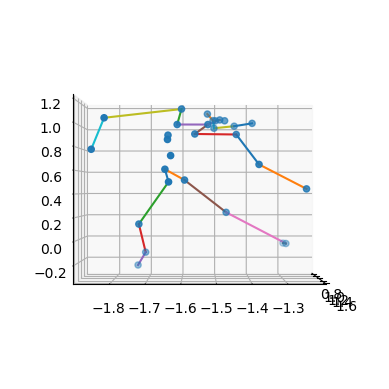

In [4]:
person = splits['poses3d'][0][0][0]

# plot person in 3d 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(person[:,0], person[:,1], person[:,2])
for edge in body_edges:
    ax.plot([person[edge[0],0], person[edge[1],0]], [person[edge[0],1], person[edge[1],1]], [person[edge[0],2], person[edge[1],2]])
ax.view_init(elev=0, azim=0)
plt.show()


In [31]:

class HiKDataset(Dataset):
    def __init__(self, dataset, data_location, sample_length=30, step_size=30, downsample_rate=6):
        self.scene = Scene.load_from_paths(
            dataset,
            os.path.join(data_location, "poses"),
            os.path.join(data_location, "scenes"),
            os.path.join(data_location, "body_models")
        )
        
        self.splits = self.scene.get_splits(sample_length, stepsize=step_size)
        self.process_data(downsample_rate)

    def process_data(self, downsample_rate):
        # Extract relevant data
        poses3d = self.splits["poses3d"]  # n_seq x n_frames x n_person x 29 x 3
        masks = self.splits["masks"]  # n_seq x n_frames x n_person
        activities = self.splits["activities"]  # n_seq x n_frames x n_person x 82

        # Transform to single-person format
        n_seq, n_frames, n_person, n_joints, n_xyz = poses3d.shape
        self.poses = rearrange(
            poses3d, "n_seq n_frames n_person n_joints n_xyz -> (n_seq n_person) n_frames n_xyz n_joints"
        )
        self.masks = rearrange(
            masks, "n_seq n_frames n_person -> (n_seq n_person) n_frames"
        )
        self.activities = rearrange(
            activities, "n_seq n_frames n_person n_activities -> (n_seq n_person) n_frames n_activities"
        )

        # Drop sequences with missing data
        valid_indices = np.all(self.masks, axis=1)

        self.poses = self.poses[valid_indices]
        self.activities = self.activities[valid_indices]

        # Downsample to reduce framerate (e.g., every 6th frame)
        self.poses = self.poses[:, ::downsample_rate, :, :]
        self.activities = self.activities[:, ::downsample_rate, :]

    def __len__(self):
        return len(self.poses)

    def __getitem__(self, idx):
        return {
            "poses": torch.tensor(self.poses[idx], dtype=torch.float32),
            "activity_label": torch.tensor(self.activities[idx, self.activities.shape[1] // 2], dtype=torch.float32)
        }

class GraphDataset(Dataset):
    def __init__(self, hik_dataset):
        self.graphs = []
        for idx in range(len(hik_dataset)):
            data = hik_dataset[idx]
            poses = data["poses"]  # n_frames x n_xyz x n_joints
            label = data["activity_label"]

            graph_data = self.create_graph(poses, label)
            self.graphs.append(graph_data)

    def create_graph(self, poses, label):
        n_frames, n_xyz, n_joints = poses.shape

        # Nodes and features
        features = poses.view(-1, n_xyz)  # Flatten frames and joints to (n_frames * n_joints, n_xyz)
        num_nodes = n_frames * n_joints

        # Edges: spatial and temporal
        edges = []

        # Spatial edges (connect neighboring joints)
        for t in range(n_frames):
            for j in range(n_joints - 1):
                node_id = t * n_joints + j
                next_node_id = t * n_joints + (j + 1)
                edges.append([node_id, next_node_id])
                edges.append([next_node_id, node_id])

        # Temporal edges (connect same joints across frames)
        for t in range(n_frames - 1):
            for j in range(n_joints):
                node_id = t * n_joints + j
                next_node_id = (t + 1) * n_joints + j
                edges.append([node_id, next_node_id])
                edges.append([next_node_id, node_id])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # Shape: [2, num_edges]

        # Create PyG Data object
        graph_data = Data(
            x=features,  # Node features
            edge_index=edge_index,  # Edges
            y=label.unsqueeze(0)  # Graph label
        )

        return graph_data

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


In [50]:
dataset = HiKDataset(dataset_name, data_location, sample_length, step_size)
graph_dataset = GraphDataset(dataset)

data_loader = DataLoader(graph_dataset, batch_size=32, shuffle=True)

# Splitting the dataset
train_size = int(0.8 * len(graph_dataset))
val_size = int(0.1 * len(graph_dataset))
test_size = len(graph_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(graph_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 319/319 [00:04<00:00, 77.61it/s]


In [82]:
graph_dataset[0]

Data(x=[145, 3], edge_index=[2, 512], y=[1, 82])

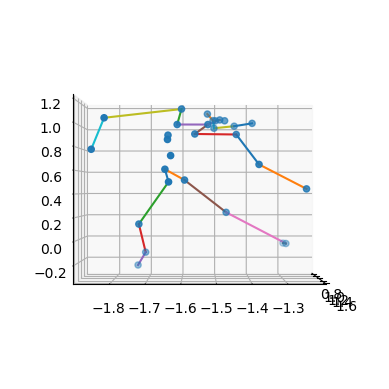

In [67]:
person_test = dataset[0]["poses"][0].T

# plot person in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(person_test[:,0], person_test[:,1], person_test[:,2])
for edge in body_edges:
    ax.plot([person_test[edge[0],0], person_test[edge[1],0]], [person_test[edge[0],1], person_test[edge[1],1]], [person_test[edge[0],2], person_test[edge[1],2]])
ax.view_init(elev=0, azim=0)
plt.show()

In [60]:
graph_dataset[0]

Data(x=[145, 3], edge_index=[2, 512], y=[1, 82])

In [47]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)

        return x


In [73]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Setup
input_dim = 3  # Node feature size (x, y, z)
hidden_dim = 512
output_dim = graph_dataset[0].y.size(1)  # Number of labels

model = GCN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()  # Multilabel classification

In [72]:
# Training Loop
def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)  # Move entire batch to the device
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation Loop
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)  # Move entire batch to the device
            out = model(batch)
            preds = (torch.sigmoid(out) > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(batch.y.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # f1 = f1_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    return f1


# Training and Validation
epochs = 10
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_f1 = evaluate(model, val_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val F1: {val_f1:.4f}")

# Testing
test_f1 = evaluate(model, test_loader)
print(f"Test F1 Score: {test_f1:.4f}")


Epoch 1/10, Train Loss: 0.1090, Val F1: 0.0074
Epoch 2/10, Train Loss: 0.0623, Val F1: 0.0140
Epoch 3/10, Train Loss: 0.0607, Val F1: 0.0113
Epoch 4/10, Train Loss: 0.0587, Val F1: 0.0157
Epoch 5/10, Train Loss: 0.0554, Val F1: 0.0189
Epoch 6/10, Train Loss: 0.0523, Val F1: 0.0193
Epoch 7/10, Train Loss: 0.0504, Val F1: 0.0230
Epoch 8/10, Train Loss: 0.0492, Val F1: 0.0225
Epoch 9/10, Train Loss: 0.0484, Val F1: 0.0272
Epoch 10/10, Train Loss: 0.0478, Val F1: 0.0296
Test F1 Score: 0.0284


In [80]:
for batch in train_loader:
    batch = batch.to(device)  # Move entire batch to the device
    # optimizer.zero_grad()
    out = model(batch)
    print(batch.y.squeeze().shape)
    break

torch.Size([32, 82])


In [76]:
out.shape

torch.Size([32, 82])